In [1]:
from neurosynth.base.dataset import Dataset
from owlready2 import get_ontology
from neurosynth.analysis import meta
import nibabel as nib
import nilearn as nil
from nilearn import plotting
from neurolang import frontend as fe

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/expression_pattern_matching.py:74: UserWarning: Warning in class ReplaceExpressionsByValues overwrites {'symbol', 'constant'} from base ExpressionWalker[typing.Any]
  warn(warn_message)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/expression_pattern_matching.py:74: UserWarning: Warning in class FirstOrderLogicSolver overw

In [2]:
onto = get_ontology('./fma.owl')
onto.load()

def get_nodes(onto, main_label, labels=[]):
    for main in onto.search(label = main_label):
        subs = list(main.subclasses())
        while subs:
            subc = subs.pop(0)
            labels.append(subc.label[0])
            subs = subs + list(subc.subclasses())
    labels = list(dict.fromkeys(labels))
    return labels

def get_subclasses(onto, main_label, apply=None):
    subclasses = dict()
    for main in onto.search(label = main_label):
        subs = [main]
        while subs:
            subc = subs.pop(0)
            temp = list(subc.subclasses())
            if len(temp) > 0:
                subclasses[subc.label[0]] = [e.label[0] for e in temp]
                subs = subs + temp
    if apply is not None:
        subclasses = apply(subclasses)
    return subclasses

def parse_isSub(subc):
    subclass = []
    for k, v in subc.items():
        for elem in v:
            subclass.append((k, elem))
    return subclass

def get_synonyms(onto, main_label, apply=None):
    synonyms = dict()
    for main in onto.search(label = main_label):
        subs = [main]
        while subs:
            subc = subs.pop(0)
            temp = list(subc.subclasses())
            syn = subc.synonym
            if len(syn) > 0:
                synonyms[subc.label[0]] = syn
            subs = subs + temp
    if apply is not None:
        synonyms = apply(synonyms)
    return synonyms

def parse_isSyn(syn):
    syns = []
    for k, v in syn.items():
        for elem in v:
            syns.append((k, elem))
            syns.append((elem, k))
    return syns

nl = fe.NeurolangDL()

nodes = get_nodes(onto, 'Lobe of cerebral hemisphere')
subc = get_subclasses(onto, 'Lobe of cerebral hemisphere', apply=parse_isSub)
syn = get_synonyms(onto, 'Lobe of cerebral hemisphere', apply=parse_isSyn)

nl.add_tuple_set(
    ((str(e),) for e in nodes),
    name='nodes'
);

nl.add_tuple_set(
    ((str(e1), str(e2),) for e1, e2 in subc),
    name='subclasses'
);

nl.add_tuple_set(
    ((str(e1), str(e2),) for e1, e2 in syn),
    name='synonyms'
);

In [3]:
dataset = Dataset('database.txt')
dataset.add_features('features.txt')

In [4]:
ids = dataset.get_studies(features='frontal lobe*', frequency_threshold=0.001)

In [5]:
len(ids)

271

In [6]:
ma = meta.MetaAnalysis(dataset, ids)
ma.save_results('.', 'frontal_lobe')

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/analysis/meta.py:134: RuntimeWarning: invalid value encountered in true_divide
  pFgA = pAgF * pF / pA
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/analysis/meta.py:139: RuntimeWarning: invalid value encountered in true_divide
  pFgA_prior = pAgF * prior / pAgF_prior


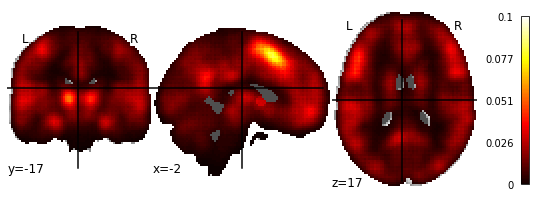

In [7]:
plotting.plot_stat_map('frontal_lobe_pA.nii.gz')

In [8]:
from neurolang.frontend.neurosynth_utils import NeuroSynthHandler

In [9]:
nsh = NeuroSynthHandler()
dataset = nsh.ns_load_dataset()
nsh = NeuroSynthHandler(ns_dataset=dataset)

In [10]:
#nsh_data = nsh.ns_region_set_from_term('frontal lobe*')
neurosynth_frontal_lobe = nl.load_neurosynth_term_regions(
    'frontal lobe*',
    name='neurosynth_frontal_lobe'
)

In [11]:
import nilearn
import nibabel as nib
from nilearn import datasets
from neurolang import regions
import numpy as np

from neurolang import expressions
from neurolang import solver_datalog_naive as sdb
from neurolang import solver_datalog_extensional_db
from neurolang import expression_walker as ew
from neurolang import datalog_chase as dc

C_ = expressions.Constant
S_ = expressions.Symbol
Imp_ = sdb.Implication
Fact_ = sdb.Fact
Eb_ = expressions.ExpressionBlock


destrieux_dataset = datasets.fetch_atlas_destrieux_2009()
destrieux_map = nib.load(destrieux_dataset['maps'])

destrieux = nl.new_symbol(name='destrieux')
d = []
for label_number, name in destrieux_dataset['labels']:
    if label_number == 0:
        continue
    name = name.decode()
    region = nl.create_region(destrieux_map, label=label_number)
    if region is None:
        continue
    name = name.replace('-', '_').replace(' ', '_')
    d.append((name.lower(), region))

destrieux = nl.add_tuple_set(d, name='destrieux')

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [12]:
x = nl.new_symbol(name='x')
y = nl.new_symbol(name='y')
val = nl.new_symbol(name='val')
isSub = nl.new_symbol(name='isSub')
isSyn = nl.new_symbol(name='isSyn')

query1 = nl.query(val(x), nl.symbols.nodes(x))
query2 = nl.query(isSyn(x, y), nl.symbols.synonyms(x, y))
query3 = nl.query(isSub(x, y), nl.symbols.subclasses(x, y))

In [14]:
nl.query(val(y), isSub('Frontal lobe', y))
#dl.query(val(y), isSyn('Lobe of cerebral hemisphere', y))

val: typing.AbstractSet[typing.Tuple[str]] = [('Right frontal lobe',), ('Left frontal lobe',)]

In [19]:
# To add a new cell, type '#%%'
# To add a new markdown cell, type '#%% [markdown]'
#%% Change working directory from the workspace root to the ipynb file location. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
    os.chdir(os.path.join(os.getcwd(), 'examples'))
    print(os.getcwd())
except:
    pass
#%%
from IPython import get_ipython


#%%
get_ipython().run_line_magic('matplotlib', 'inline')


#%%
import nilearn
from nilearn import plotting
import nibabel as nib
import numpy as np


#%%
from neurolang import regions
from neurolang import region_solver


#%%
from neurolang import expressions
from neurolang import solver_datalog_naive as sdb
from neurolang import solver_datalog_extensional_db
from neurolang import expression_walker as ew
from neurolang import datalog_chase as dc


C_ = expressions.Constant
S_ = expressions.Symbol
Imp_ = sdb.Implication
Fact_ = sdb.Fact
Eb_ = expressions.ExpressionBlock


#%%
atlas_destrieux = nilearn.datasets.fetch_atlas_destrieux_2009()


#%%
image = nib.load(atlas_destrieux['maps'])
image_data = image.get_data()


#%%
region_dict = {}
for label, name in atlas_destrieux['labels']:
    
    print(label)
    if label == 0 or label == 42 or label == 117:
        continue
    r = regions.ExplicitVBR(np.transpose((image_data == label).nonzero()), image.affine, image_dim=image.shape)
    if r.voxels.shape[0] > 0:
        region_dict[name.decode('utf8')] = r
    


#%%
destrieux = sdb.Symbol('Destrieux')
destrieux_facts = [
    Fact_(destrieux(
        C_(name), 
        C_(region)
    ))
    for name, region in region_dict.items()
]


#%%
from typing import Any

class Datalog(
    region_solver.RegionSolver,
    dc.sdb.DatalogBasic,
    solver_datalog_extensional_db.ExtensionalDatabaseSolver,
    ew.ExpressionBasicEvaluator
):
    def function_lh(self, x: str) -> bool:
        return x.startswith('L ')
    
    def function_rh(self, x: str) -> bool:
        return x.startswith('R ')


#%%
plotting.plot_roi(region_dict['L S_temporal_sup'].spatial_image());


#%%
superior_sts_l = S_('region_l_sts')
r = S_('r')
name = S_('name')

t1 = Imp_(
    S_('superior_sts_l')(name),
        destrieux(C_('L S_temporal_sup'), superior_sts_l) &
        S_('anatomical_superior_of')(r, superior_sts_l) &
        S_('lh')(name) & 
        destrieux(name, r)
)


#%%
datalog_program = Eb_(
    destrieux_facts + [
    t1,
])


#%%
dl = Datalog()
dl.walk(datalog_program);


#%%
solution = dc.build_chase_solution(dl)


#%%
solution


#%%
rsbv = ew.ReplaceExpressionsByValues({})
result = rsbv.walk(solution['superior_sts_l'])
result


#%%





0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


TypeError: argument of type 'SpatialHeader' is not iterable

In [20]:
region_dict['L S_temporal_sup'].spatial_image()

In [22]:
plotting.plot_roi(region_dict['L S_temporal_sup'].spatial_image())

TypeError: argument of type 'SpatialHeader' is not iterable